# Demo of graph optimisation on real graph to segment structures:

# TODO: implement edge classification predictions just as in the dummy graph:

In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


In [2]:
import torch

from scipy.special import softmax


In [3]:
from grace.base import GraphAttrs

from grace.simulate import random_graph, random_graph_mixed_motifs
from grace.models.datasets import dataset_from_graph
from grace.models.optimise import optimise_graph

from grace.io.image_dataset import ImageGraphDataset
from grace.models.feature_extractor import FeatureExtractor


### Load an example image + build graph:

In [4]:
IMAGE_DIR = "/Users/kulicna/Desktop/classifier/data/"
IMAGE_DIR, os.path.isdir(IMAGE_DIR)

('/Users/kulicna/Desktop/classifier/data/', True)

In [5]:
# class Compose(object):
#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, image, target):
#         for t in self.transforms:
#             image, target = t(image, target)
#         return image, target
    
def normalize8(I):
    I = np.array(I)
    mn = I.min()
    mx = I.max()

    mx -= mn

    I = ((I - mn)/mx) * 255
    return I.astype(np.uint8)


In [6]:
image_graph_dataset = ImageGraphDataset(
    image_dir=IMAGE_DIR,
    grace_dir=IMAGE_DIR,
    transform=lambda x,y: (x,y),
    image_filetype="mrc",
)

In [7]:
image_graph_dataset

In [8]:
for image, graph_data in image_graph_dataset:
    print (image.shape, graph_data.keys(), graph_data)

torch.Size([3710, 3838]) dict_keys(['graph', 'metadata']) {'graph': <networkx.classes.graph.Graph object at 0x23a3c1350>, 'metadata': {'image_filename': 'FoilHole_24680421_Data_24671727_24671728_20181024_2216-78563_noDW'}}


In [9]:
graph = graph_data['graph']
graph.number_of_nodes(), graph.number_of_edges()


(198, 575)

In [14]:
single_node = graph.nodes()[0]
single_node

{<GraphAttrs.NODE_X: 'x'>: 1193.3724365234375,
 <GraphAttrs.NODE_Y: 'y'>: 3504.8525390625,
 <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
 <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>,
 <GraphAttrs.NODE_FEATURES: 'features'>: None}

In [15]:
pos = {idx: [node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]] for idx, node in graph.nodes(data=True)}
len(pos)

198

In [16]:
coords_x, coords_y = np.transpose(list(pos.values()))
coords_x.shape, coords_y.shape

((198,), (198,))

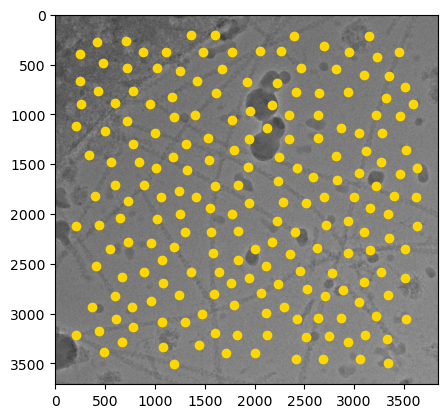

In [17]:
plt.imshow(image, cmap="binary_r")
plt.scatter(coords_x, coords_y, color='gold')
plt.show()

### Now extract the features from each node patch:

In [18]:
extractor_model = torch.load("/Users/kulicna/Desktop/classifier/extractor/resnet152.pt")
extractor_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [19]:
feature_extractor = FeatureExtractor(model=extractor_model)
feature_extractor

FeatureExtractor(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [20]:
image_ext, graph_ext = feature_extractor(image=image, graph=graph_data)
type(image_ext), type(graph_ext)

/Users/kulicna/anaconda3/envs/grace-env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Tensor, dict)

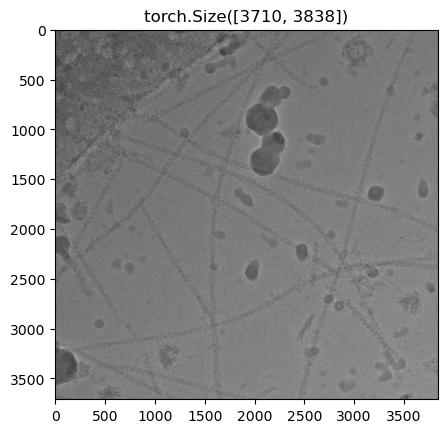

In [21]:
# The image is unchanged, but the features are added to the graph_data:
plt.imshow(image_ext, cmap='binary_r')
plt.title(image_ext.shape)
plt.show()

### Each node now has the feature vector appended to it:

In [22]:
G = graph_ext['graph']
single_node = G.nodes()[0]
single_node, single_node[GraphAttrs.NODE_FEATURES].shape

({<GraphAttrs.NODE_X: 'x'>: 1193.3724365234375,
  <GraphAttrs.NODE_Y: 'y'>: 3504.8525390625,
  <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
  <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>,
  <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.8661, 0.4480, 0.8657,  ..., 0.4219, 0.3931, 0.3851])},
 torch.Size([2048]))

## Now run inference:

### Load the pre-trained models for node & edge classification:

In [23]:
classifier_model = torch.load("/Users/kulicna/Desktop/classifier/runs/2023-06-13_16-42-48/classifier.pt")
classifier_model

GCN(
  (conv1): GCNConv(2048, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (node_classifier): Linear(in_features=32, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
# classified_graph = classifier_model.forward(x=G, edge_index=)

In [ ]:
# def classify_subgraph(graph, classifier):
     

In [44]:
def get_node_predictions(G, model):
    model.eval()

    predictions = []
    dataset = dataset_from_graph(G)

    for data in dataset:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index)
        out = out[0]
        pred = out.argmax(dim=1)
        probs = softmax(out.detach().numpy())

        predictions.append((int(pred.numpy()), probs))

    # this is the prediction that the node is in the object
    for (_, node), pred in zip(G.nodes.data(), predictions):
        # for a FP, we want this to be the prob that it's *NOT* in the object
        # print(pred)
        node[GraphAttrs.NODE_PREDICTION] = np.clip(float(pred[1][0, 0]), 0, 1)

    return G

In [45]:
graph_predicted = get_node_predictions(G, classifier_model)
graph_predicted


In [46]:
single_node = graph_predicted.nodes()[0]
single_node, single_node[GraphAttrs.NODE_PREDICTION]x

({<GraphAttrs.NODE_X: 'x'>: 1193.3724365234375,
  <GraphAttrs.NODE_Y: 'y'>: 3504.8525390625,
  <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
  <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>,
  <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.8661, 0.4480, 0.8657,  ..., 0.4219, 0.3931, 0.3851]),
  <GraphAttrs.NODE_PREDICTION: 'node_prediction'>: 3.965026917907011e-10},
 3.965026917907011e-10)

# Continue here!

In [25]:
def get_edge_predictions(G, model):
    # TODO
    pass

In [26]:
get_node_predictions(G, classifier_model)
# get_edge_predictions(G, model_edges)

AttributeError: 'tuple' object has no attribute 'argmax'

In [11]:
for image, graph_data in image_graph_dataset:
    print (type(image), image.shape, image.dtype, type(graph_data), len(graph_data))

<class 'torch.Tensor'> torch.Size([3710, 3838]) torch.float32 <class 'dict'> 2


In [12]:
image, graph_data = image_graph_dataset

ValueError: not enough values to unpack (expected 2, got 1)

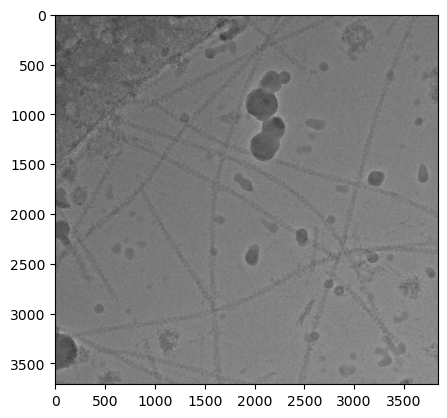

In [58]:
graph_data

{'graph': <networkx.classes.graph.Graph at 0x23ad81090>,
 'metadata': {'image_filename': 'FoilHole_24680421_Data_24671727_24671728_20181024_2216-78563_noDW'}}

In [60]:
type(graph_data['graph']), len(graph_data['graph'])

(networkx.classes.graph.Graph, 198)

In [62]:
graph = graph_data['graph']
graph.number_of_nodes(), graph.number_of_edges()

(198, 575)

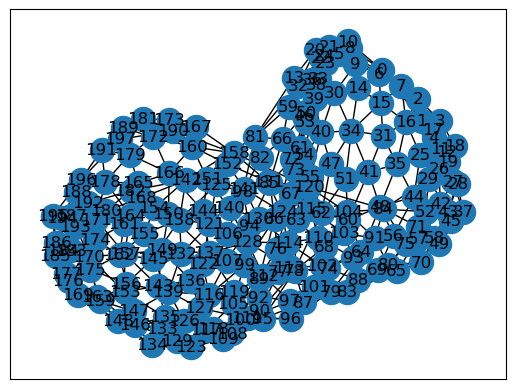

In [69]:
nx.draw_networkx(graph)

In [52]:
type(image_graph_dataset), len(image_graph_dataset)

(grace.io.image_dataset.ImageGraphDataset, 1)

In [17]:
for image, graph_data in image_graph_dataset:
    print (type(image), type(graph_data), len(graph_data))

<class 'torch.Tensor'> <class 'dict'> 2


### Load a dummy graph:

In [4]:
G = random_graph(n_motifs=5, n_chaff=100, scale=1.0, density=0.075, motif="line")

In [42]:
single_node = G.nodes(data=True)[0]
single_node

{'x': 0.47110048570734453,
 'y': 0.36493122065010286,
 'features': array([0.86403544, 0.2659364 , 0.12030389]),
 'label': 0,
 'object_idx': 0}

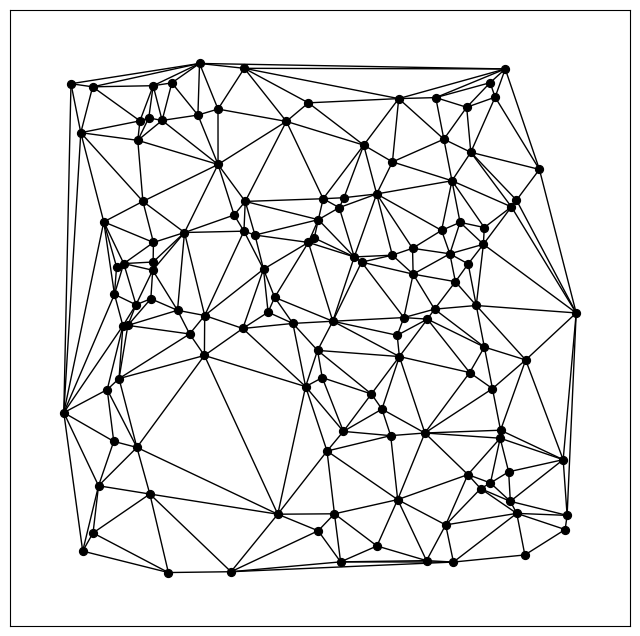

In [5]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in G.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(G, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

### Understand how the edge weights are distributed:

In [35]:
def plot_node_and_edge_label_distribution(graph: nx.Graph, attr: str = "hello") -> None: 

    # node_labels = [node[GraphAttrs.NODE_GROUND_TRUTH] for _, node in graph.nodes(data=True)]
    node_labels = [node.keys() for _, node in G.nodes(data=True)]
    print (node_labels)
    node_labels = [node['features'] for _, node in G.nodes(data=True)]
    print (node_labels)
    node_labels = [node['label'] for _, node in G.nodes(data=True)]
    print (node_labels)
    plt.hist(node_labels, label=f"GT nodes: {sum(node_labels)} / {len(node_labels)}")
    plt.legend()
    plt.show()


[dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x', 'y', 'features', 'label', 'object_idx']), dict_keys(['x

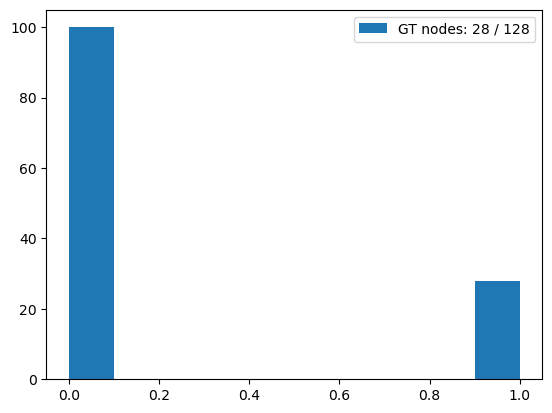

In [36]:
plot_node_and_edge_label_distribution(graph=G)

### Optimise the dummy graph:

In [81]:
# NOTE(arl): this is *super* hacky - just to see if the optimisation works

def update_graph_dummy(G):

    # G = get_predictions(G, model)

    nodes = list(G.nodes.data())

    for _, node in nodes:
        pd = np.random.random()*0.5
        if node["label"] > 0:
            node[GraphAttrs.NODE_PREDICTION] = pd
        else:
            node[GraphAttrs.NODE_PREDICTION] = 1-pd

    
    for edge in G.edges.data():
        pd = np.random.random()*0.1
        _, e_i = nodes[edge[0]]
        _, e_j = nodes[edge[1]]
        
        if e_i["object_idx"] == e_j["object_idx"] and e_i["label"] > 0:
            edge[2][GraphAttrs.EDGE_PREDICTION] = 1 - pd
        else:
            edge[2][GraphAttrs.EDGE_PREDICTION] = pd 


In [82]:
update_graph_dummy(G)


(array([ 3.,  0.,  3.,  3.,  6.,  4.,  4.,  1.,  0.,  2., 12., 16., 11.,
        11.,  9.,  7.,  7., 10., 11.,  6.]),
 array([0.00579444, 0.055498  , 0.10520156, 0.15490512, 0.20460868,
        0.25431223, 0.30401579, 0.35371935, 0.40342291, 0.45312647,
        0.50283002, 0.55253358, 0.60223714, 0.6519407 , 0.70164426,
        0.75134782, 0.80105137, 0.85075493, 0.90045849, 0.95016205,
        0.99986561]),
 <BarContainer object of 20 artists>)

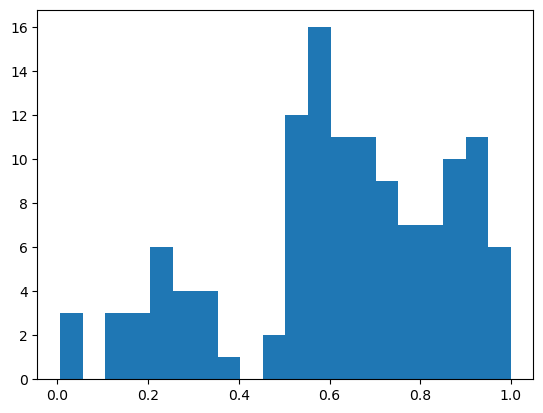

In [83]:
node_labels = [node[GraphAttrs.NODE_PREDICTION] for _, node in G.nodes(data=True)]
plt.hist(node_labels, bins=20)


(array([17., 12.,  5.,  5.,  9.,  6.,  6., 13., 13., 14.]),
 array([0.00052705, 0.05036135, 0.10019565, 0.15002995, 0.19986425,
        0.24969856, 0.29953286, 0.34936716, 0.39920146, 0.44903576,
        0.49887006]),
 <BarContainer object of 10 artists>)

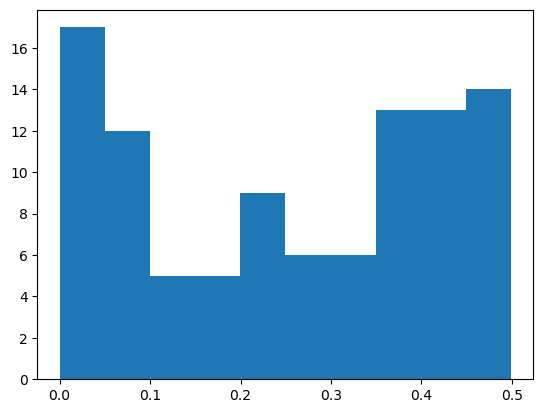

In [84]:
n = [np.random.random()*0.5 for _ in range(100)]
plt.hist(n)

In [85]:
node_labels = [node['label'] for _, node in G.nodes(data=True)]
node_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [86]:
x = optimise_graph(G)

### Visualise the graph & individual objects:

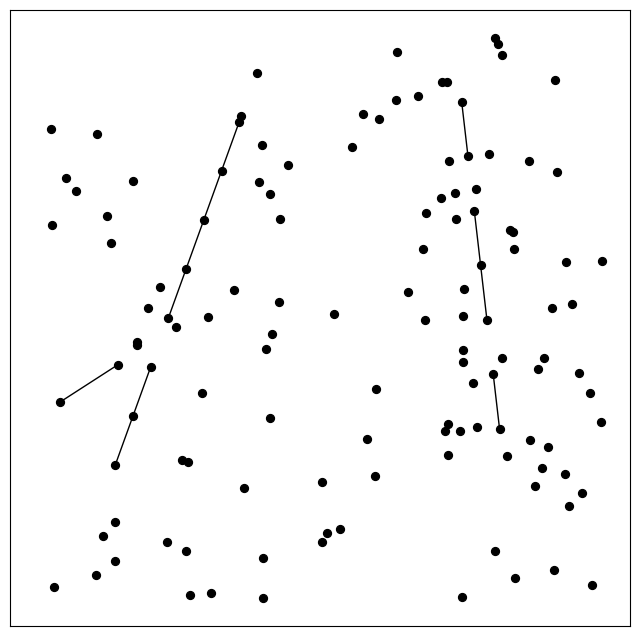

In [87]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)
plt.show()

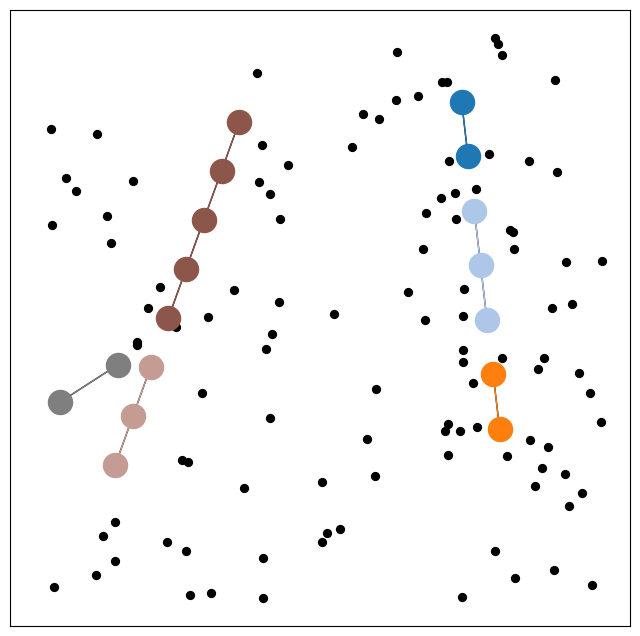

In [88]:

# plt.ion()

pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

# get each connected subgraph and draw it with a different colour
cc = nx.connected_components(x)
for index, sg in enumerate(cc):
    # print (index, sg)

    if len(sg) <= 1:
        continue

    c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
    sg = x.subgraph(sg).copy()
    nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

plt.show()

## TODO: implement on real graph data!

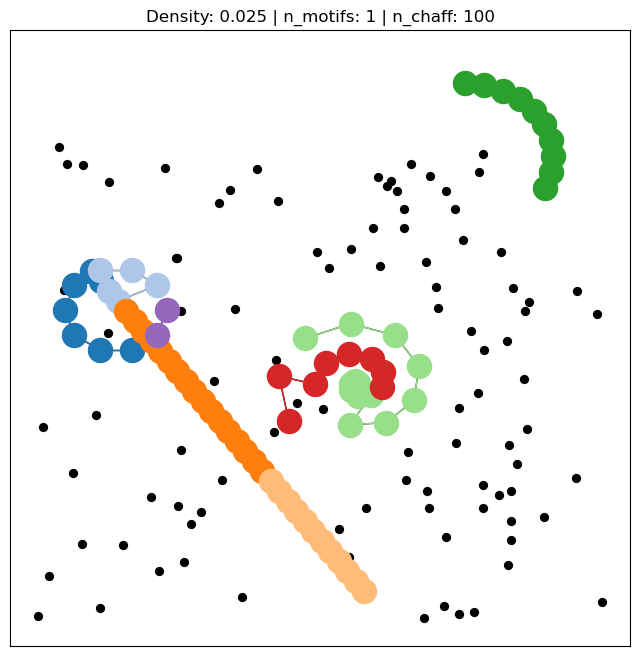

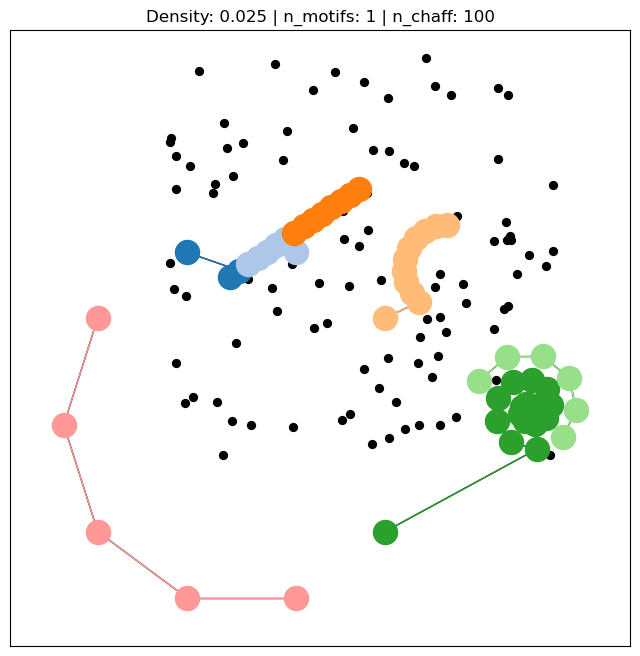

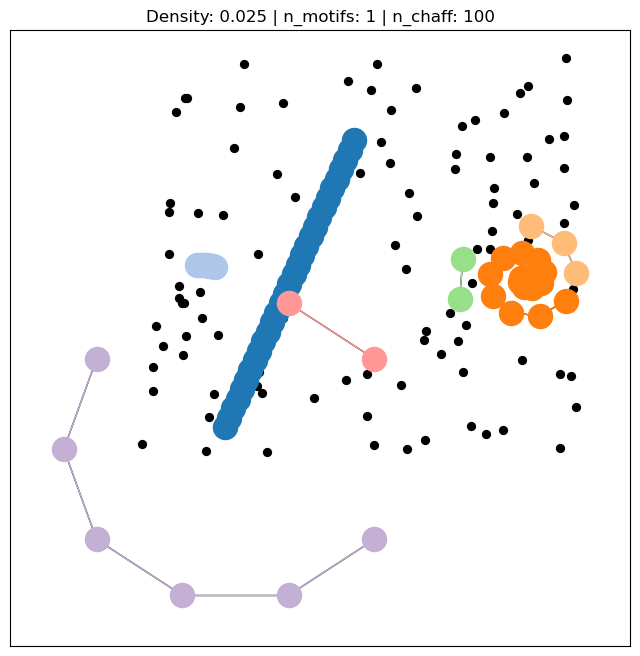

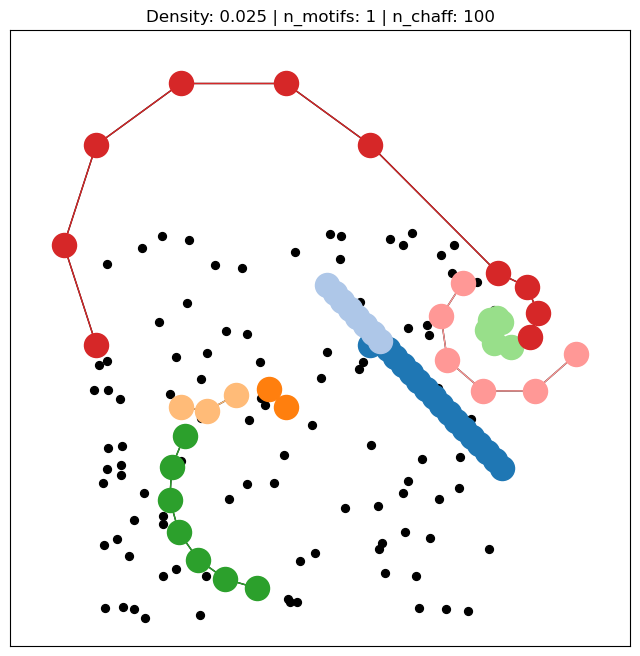

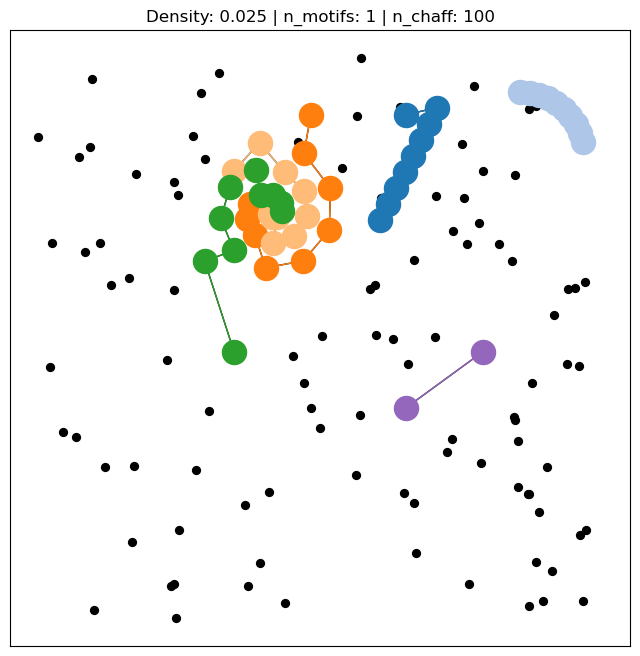

In [13]:
num_trials = 5
density = 0.025
n_motifs = 1
n_chaff = 100

for i in range(num_trials):
    # G = random_graph(n_motifs=n_motifs, n_chaff=n_chaff, scale=1.0, density=density)
    G = random_graph_mixed_motifs(n_motifs=n_motifs, n_chaff=n_chaff, scale=1.0, density=density)
    update_graph_dummy(G)
    x = optimise_graph(G)
    
    # Plot:
    # plt.ion()

    pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
    fig, ax = plt.subplots(figsize=(8, 8))

    # draw all nodes/vertices in the graph, including those not determined to be 
    # part of the objects
    nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

    # get each connected subgraph and draw it with a different colour
    cc = nx.connected_components(x)
    for index, sg in enumerate(cc):
        
        if len(sg) <= 1:
            continue

        c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
        sg = x.subgraph(sg).copy()
        plt.title(f"Density: {density} | n_motifs: {n_motifs} | n_chaff: {n_chaff}")
        nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

    plt.show()